In [ ]:
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, History
import numpy as np
from PIL import Image

In [ ]:
# Step 1: Create directories
os.makedirs('/content/data', exist_ok=True)
os.makedirs('/content/augmented_data', exist_ok=True)

# Extract zip files
zip_files = ['akeic.zip', 'df.zip', 'vasc.zip']
for zip_file in zip_files:
    with zipfile.ZipFile(f'/content/{zip_file}', 'r') as zip_ref:
        zip_ref.extractall('/content/data')

In [ ]:
# Step 2: Generate and save augmented images
augmentation_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Number of augmented images to generate per original image
num_aug_per_image = 5

# Generate and save augmented images for each class
for class_name in os.listdir('/content/data'):
    class_path = os.path.join('/content/data', class_name)
    aug_class_path = os.path.join('/content/augmented_data', class_name)
    os.makedirs(aug_class_path, exist_ok=True)

    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
                x = tf.keras.preprocessing.image.img_to_array(img)
                x = x.reshape((1,) + x.shape)

                i = 0
                for batch in augmentation_datagen.flow(x, batch_size=1):
                    aug_img = Image.fromarray((batch[0] * 255).astype(np.uint8))
                    aug_img.save(os.path.join(aug_class_path, f'aug_{i}_{img_name}'))
                    i += 1
                    if i >= num_aug_per_image:
                        break

In [ ]:
# Step 3: Create combined data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Create generators for both original and augmented data
train_generator = train_datagen.flow_from_directory(
    '/content/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 648 images belonging to 3 classes.
Found 159 images belonging to 3 classes.


In [ ]:
# Step 4: Load ResNet50 Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Apply Attention Mechanism
x = base_model.output

# Attention mechanism on the feature map
attention = AdditiveAttention()([x, x])

# Apply Global Average Pooling
x = GlobalAveragePooling2D()(attention)

# Add Multiple Fully Connected Layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Final Output Layer
predictions = Dense(3, activation='softmax')(x)

# Build the final model
model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Step 5: Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Step 6: Set up checkpoints
checkpoint = ModelCheckpoint('/content/resnet50_model_skin.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)

# History object for plotting
history = History()

In [ ]:
# Step 7: Train Model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint, history]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.2591 - loss: 1.6788
Epoch 1: val_loss improved from inf to 1.10759, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 35s 898ms/step - accuracy: 0.2601 - loss: 1.6736 - val_accuracy: 0.3333 - val_loss: 1.1076
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3353 - loss: 1.3177
Epoch 2: val_loss did not improve from 1.10759
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.3357 - loss: 1.3161 - val_accuracy: 0.3333 - val_loss: 1.1125
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.3517 - loss: 1.2529
Epoch 3: val_loss improved from 1.10759 to 1.10532, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.3504 - loss: 1.2537 - val_accuracy: 0.3333 - val_loss: 1.1053
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.2886 - loss: 1.2867
Epoch 4: val_loss improved from 1.10532 to 1.10060, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.2905 - loss: 1.2845 - val_accuracy: 0.3333 - val_loss: 1.1006
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.3517 - loss: 1.1765
Epoch 5: val_loss improved from 1.10060 to 1.10011, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - accuracy: 0.3514 - loss: 1.1759 - val_accuracy: 0.3333 - val_loss: 1.1001
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.3336 - loss: 1.1262
Epoch 6: val_loss improved from 1.10011 to 1.09922, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.3349 - loss: 1.1264 - val_accuracy: 0.3333 - val_loss: 1.0992
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3424 - loss: 1.2024
Epoch 7: val_loss improved from 1.09922 to 1.09818, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.3424 - loss: 1.2015 - val_accuracy: 0.3333 - val_loss: 1.0982
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.3570 - loss: 1.1641
Epoch 8: val_loss did not improve from 1.09818
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.3561 - loss: 1.1637 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.3053 - loss: 1.1779
Epoch 9: val_loss did not improve from 1.09818
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.3060 - loss: 1.1773 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.3501 - loss: 1.1243
Epoch 10: val_loss improved from 1.09818 to 1.09734, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.3491 - loss: 1.1247 - val_accuracy: 0.3333 - val_loss: 1.0973
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.3580 - loss: 1.1255
Epoch 11: val_loss improved from 1.09734 to 1.09575, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.3580 - loss: 1.1255 - val_accuracy: 0.3333 - val_loss: 1.0958
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3456 - loss: 1.1020
Epoch 12: val_loss improved from 1.09575 to 1.09563, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.3451 - loss: 1.1026 - val_accuracy: 0.3333 - val_loss: 1.0956
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.3420 - loss: 1.1227
Epoch 13: val_loss did not improve from 1.09563
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.3423 - loss: 1.1225 - val_accuracy: 0.3333 - val_loss: 1.0962
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.3425 - loss: 1.1101
Epoch 14: val_loss improved from 1.09563 to 1.09530, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.3425 - loss: 1.1103 - val_accuracy: 0.3333 - val_loss: 1.0953
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.3463 - loss: 1.1238
Epoch 15: val_loss did not improve from 1.09530
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.3465 - loss: 1.1235 - val_accuracy: 0.4843 - val_loss: 1.0956
Epoch 16/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.3509 - loss: 1.1102
Epoch 16: val_loss improved from 1.09530 to 1.09474, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.3505 - loss: 1.1108 - val_accuracy: 0.4340 - val_loss: 1.0947
Epoch 17/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.3367 - loss: 1.1273
Epoch 17: val_loss did not improve from 1.09474
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.3366 - loss: 1.1272 - val_accuracy: 0.3333 - val_loss: 1.0955
Epoch 18/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.3434 - loss: 1.1344
Epoch 18: val_loss did not improve from 1.09474
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.3440 - loss: 1.1338 - val_accuracy: 0.6101 - val_loss: 1.0956
Epoch 19/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.3477 - loss: 1.1190
Epoch 19: val_loss improved from 1.09474 to 1.09428, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - accuracy: 0.3481 - loss: 1.1189 - val_accuracy: 0.3648 - val_loss: 1.0943
Epoch 20/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.4055 - loss: 1.0888
Epoch 20: val_loss did not improve from 1.09428
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.4046 - loss: 1.0893 - val_accuracy: 0.3333 - val_loss: 1.0952
Epoch 21/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.3159 - loss: 1.1161
Epoch 21: val_loss did not improve from 1.09428
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.3168 - loss: 1.1159 - val_accuracy: 0.3333 - val_loss: 1.0956
Epoch 22/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3638 - loss: 1.1131
Epoch 22: val_loss did not improve from 1.09428
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.3638 - loss: 1.1128 - val_accuracy: 0.3333 - val_loss: 1.0947
Epoch 23/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.3744 - loss: 1.0968
Epoch 23: val_loss did not improve f

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.3306 - loss: 1.1265 - val_accuracy: 0.3333 - val_loss: 1.0941
Epoch 25/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.3338 - loss: 1.1123
Epoch 25: val_loss improved from 1.09411 to 1.09198, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.3342 - loss: 1.1121 - val_accuracy: 0.3333 - val_loss: 1.0920
Epoch 26/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.3196 - loss: 1.1223
Epoch 26: val_loss did not improve from 1.09198
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.3210 - loss: 1.1216 - val_accuracy: 0.3333 - val_loss: 1.0921
Epoch 27/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.3059 - loss: 1.1303
Epoch 27: val_loss did not improve from 1.09198
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.3072 - loss: 1.1297 - val_accuracy: 0.3333 - val_loss: 1.0929
Epoch 28/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.3684 - loss: 1.1037
Epoch 28: val_loss did not improve from 1.09198
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.3668 - loss: 1.1041 - val_accuracy: 0.3333 - val_loss: 1.0937
Epoch 29/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.3304 - loss: 1.1109
Epoch 29: val_loss did not improve f

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.3858 - loss: 1.0930 - val_accuracy: 0.3333 - val_loss: 1.0919
Epoch 33/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3925 - loss: 1.0985
Epoch 33: val_loss improved from 1.09186 to 1.09156, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.3916 - loss: 1.0990 - val_accuracy: 0.3333 - val_loss: 1.0916
Epoch 34/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.3521 - loss: 1.1041
Epoch 34: val_loss did not improve from 1.09156
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.3523 - loss: 1.1039 - val_accuracy: 0.3333 - val_loss: 1.0939
Epoch 35/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.3593 - loss: 1.1000
Epoch 35: val_loss did not improve from 1.09156
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.3593 - loss: 1.0999 - val_accuracy: 0.5220 - val_loss: 1.0924
Epoch 36/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3355 - loss: 1.1102
Epoch 36: val_loss did not improve from 1.09156
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.3355 - loss: 1.1099 - val_accuracy: 0.5786 - val_loss: 1.0921
Epoch 37/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.3412 - loss: 1.0981
Epoch 37: val_loss did not improve f

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.3844 - loss: 1.0949 - val_accuracy: 0.3396 - val_loss: 1.0907
Epoch 40/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.3900 - loss: 1.0912
Epoch 40: val_loss improved from 1.09069 to 1.08740, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.3897 - loss: 1.0911 - val_accuracy: 0.3648 - val_loss: 1.0874
Epoch 41/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.3287 - loss: 1.1036
Epoch 41: val_loss improved from 1.08740 to 1.08453, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.3299 - loss: 1.1033 - val_accuracy: 0.4465 - val_loss: 1.0845
Epoch 42/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.3934 - loss: 1.0887
Epoch 42: val_loss improved from 1.08453 to 1.08418, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.3924 - loss: 1.0889 - val_accuracy: 0.5723 - val_loss: 1.0842
Epoch 43/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.3732 - loss: 1.0959
Epoch 43: val_loss improved from 1.08418 to 1.08121, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.3746 - loss: 1.0955 - val_accuracy: 0.5912 - val_loss: 1.0812
Epoch 44/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.3230 - loss: 1.1018
Epoch 44: val_loss improved from 1.08121 to 1.07968, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.3246 - loss: 1.1015 - val_accuracy: 0.5283 - val_loss: 1.0797
Epoch 45/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.3528 - loss: 1.0964
Epoch 45: val_loss improved from 1.07968 to 1.07810, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.3533 - loss: 1.0965 - val_accuracy: 0.6101 - val_loss: 1.0781
Epoch 46/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4159 - loss: 1.0880
Epoch 46: val_loss did not improve from 1.07810
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.4152 - loss: 1.0879 - val_accuracy: 0.5849 - val_loss: 1.0821
Epoch 47/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.4020 - loss: 1.0882
Epoch 47: val_loss did not improve from 1.07810
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.4000 - loss: 1.0885 - val_accuracy: 0.5975 - val_loss: 1.0791
Epoch 48/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.3817 - loss: 1.0951
Epoch 48: val_loss did not improve from 1.07810
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.3820 - loss: 1.0949 - val_accuracy: 0.5597 - val_loss: 1.0812
Epoch 49/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.3888 - loss: 1.0944
Epoch 49: val_loss improved from 1.0

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.3896 - loss: 1.0940 - val_accuracy: 0.6164 - val_loss: 1.0777
Epoch 50/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.4091 - loss: 1.0795
Epoch 50: val_loss improved from 1.07774 to 1.07187, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - accuracy: 0.4093 - loss: 1.0797 - val_accuracy: 0.4969 - val_loss: 1.0719
Epoch 51/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.3486 - loss: 1.0953
Epoch 51: val_loss improved from 1.07187 to 1.06734, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.3488 - loss: 1.0953 - val_accuracy: 0.6038 - val_loss: 1.0673
Epoch 52/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.3508 - loss: 1.0943
Epoch 52: val_loss did not improve from 1.06734
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.3528 - loss: 1.0937 - val_accuracy: 0.5031 - val_loss: 1.0700
Epoch 53/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.3624 - loss: 1.0884
Epoch 53: val_loss did not improve from 1.06734
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.3622 - loss: 1.0884 - val_accuracy: 0.4465 - val_loss: 1.0689
Epoch 54/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.4130 - loss: 1.0677
Epoch 54: val_loss improved from 1.06734 to 1.05720, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.4128 - loss: 1.0680 - val_accuracy: 0.6226 - val_loss: 1.0572
Epoch 55/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.3798 - loss: 1.0969
Epoch 55: val_loss improved from 1.05720 to 1.05469, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - accuracy: 0.3800 - loss: 1.0964 - val_accuracy: 0.5849 - val_loss: 1.0547
Epoch 56/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4185 - loss: 1.0776
Epoch 56: val_loss improved from 1.05469 to 1.05375, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - accuracy: 0.4169 - loss: 1.0779 - val_accuracy: 0.5660 - val_loss: 1.0537
Epoch 57/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.4330 - loss: 1.0683
Epoch 57: val_loss improved from 1.05375 to 1.04949, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.4323 - loss: 1.0684 - val_accuracy: 0.6226 - val_loss: 1.0495
Epoch 58/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.4156 - loss: 1.0725
Epoch 58: val_loss improved from 1.04949 to 1.04629, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.4148 - loss: 1.0728 - val_accuracy: 0.6541 - val_loss: 1.0463
Epoch 59/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.3855 - loss: 1.0743
Epoch 59: val_loss improved from 1.04629 to 1.04549, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.3855 - loss: 1.0745 - val_accuracy: 0.5723 - val_loss: 1.0455
Epoch 60/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4383 - loss: 1.0631
Epoch 60: val_loss improved from 1.04549 to 1.04011, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.4374 - loss: 1.0632 - val_accuracy: 0.5597 - val_loss: 1.0401
Epoch 61/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.3877 - loss: 1.0719
Epoch 61: val_loss improved from 1.04011 to 1.03398, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.3882 - loss: 1.0719 - val_accuracy: 0.6541 - val_loss: 1.0340
Epoch 62/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.4640 - loss: 1.0500
Epoch 62: val_loss improved from 1.03398 to 1.02636, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.4630 - loss: 1.0504 - val_accuracy: 0.5346 - val_loss: 1.0264
Epoch 63/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.4410 - loss: 1.0609
Epoch 63: val_loss improved from 1.02636 to 1.01525, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - accuracy: 0.4403 - loss: 1.0608 - val_accuracy: 0.5975 - val_loss: 1.0152
Epoch 64/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.4915 - loss: 1.0414
Epoch 64: val_loss improved from 1.01525 to 1.01152, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.4898 - loss: 1.0417 - val_accuracy: 0.6101 - val_loss: 1.0115
Epoch 65/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4557 - loss: 1.0441
Epoch 65: val_loss improved from 1.01152 to 1.01001, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.4552 - loss: 1.0441 - val_accuracy: 0.4969 - val_loss: 1.0100
Epoch 66/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.4789 - loss: 1.0267
Epoch 66: val_loss improved from 1.01001 to 0.99456, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.4784 - loss: 1.0271 - val_accuracy: 0.4969 - val_loss: 0.9946
Epoch 67/100
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.4560 - loss: 1.0420
Epoch 67: val_loss improved from 0.99456 to 0.97679, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.4566 - loss: 1.0416 - val_accuracy: 0.5786 - val_loss: 0.9768
Epoch 68/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4807 - loss: 1.0344
Epoch 68: val_loss improved from 0.97679 to 0.97508, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.4806 - loss: 1.0339 - val_accuracy: 0.4780 - val_loss: 0.9751
Epoch 69/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.4606 - loss: 1.0462
Epoch 69: val_loss improved from 0.97508 to 0.95283, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.4621 - loss: 1.0451 - val_accuracy: 0.6038 - val_loss: 0.9528
Epoch 70/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5120 - loss: 1.0154
Epoch 70: val_loss improved from 0.95283 to 0.94549, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.5126 - loss: 1.0151 - val_accuracy: 0.6101 - val_loss: 0.9455
Epoch 71/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.4962 - loss: 1.0050
Epoch 71: val_loss did not improve from 0.94549
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.4962 - loss: 1.0051 - val_accuracy: 0.4843 - val_loss: 0.9497
Epoch 72/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5176 - loss: 0.9879
Epoch 72: val_loss improved from 0.94549 to 0.92049, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - accuracy: 0.5168 - loss: 0.9882 - val_accuracy: 0.6289 - val_loss: 0.9205
Epoch 73/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.4846 - loss: 1.0143
Epoch 73: val_loss improved from 0.92049 to 0.91675, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.4851 - loss: 1.0138 - val_accuracy: 0.6101 - val_loss: 0.9167
Epoch 74/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.4908 - loss: 0.9942
Epoch 74: val_loss improved from 0.91675 to 0.88859, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.4909 - loss: 0.9941 - val_accuracy: 0.6038 - val_loss: 0.8886
Epoch 75/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.5056 - loss: 0.9875
Epoch 75: val_loss did not improve from 0.88859
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.5051 - loss: 0.9877 - val_accuracy: 0.5597 - val_loss: 0.9018
Epoch 76/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5450 - loss: 0.9638
Epoch 76: val_loss did not improve from 0.88859
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.5455 - loss: 0.9633 - val_accuracy: 0.5283 - val_loss: 0.8896
Epoch 77/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5273 - loss: 0.9652
Epoch 77: val_loss did not improve from 0.88859
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.5260 - loss: 0.9665 - val_accuracy: 0.5220 - val_loss: 0.9088
Epoch 78/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.5007 - loss: 0.9771
Epoch 78: val_loss improved from 0.8

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.5019 - loss: 0.9762 - val_accuracy: 0.5660 - val_loss: 0.8708
Epoch 79/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5355 - loss: 0.9315
Epoch 79: val_loss improved from 0.87081 to 0.83066, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.5356 - loss: 0.9313 - val_accuracy: 0.6541 - val_loss: 0.8307
Epoch 80/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5041 - loss: 0.9297
Epoch 80: val_loss did not improve from 0.83066
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.5057 - loss: 0.9291 - val_accuracy: 0.5849 - val_loss: 0.8337
Epoch 81/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5083 - loss: 0.9128
Epoch 81: val_loss improved from 0.83066 to 0.82910, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - accuracy: 0.5108 - loss: 0.9123 - val_accuracy: 0.5597 - val_loss: 0.8291
Epoch 82/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5054 - loss: 0.9448
Epoch 82: val_loss did not improve from 0.82910
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.5059 - loss: 0.9447 - val_accuracy: 0.5220 - val_loss: 0.8476
Epoch 83/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5022 - loss: 0.9491
Epoch 83: val_loss improved from 0.82910 to 0.82751, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.5031 - loss: 0.9490 - val_accuracy: 0.5912 - val_loss: 0.8275
Epoch 84/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5514 - loss: 0.8952
Epoch 84: val_loss improved from 0.82751 to 0.81169, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.5514 - loss: 0.8952 - val_accuracy: 0.5849 - val_loss: 0.8117
Epoch 85/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5494 - loss: 0.8923
Epoch 85: val_loss improved from 0.81169 to 0.78794, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.5488 - loss: 0.8927 - val_accuracy: 0.6038 - val_loss: 0.7879
Epoch 86/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5195 - loss: 0.9242
Epoch 86: val_loss did not improve from 0.78794
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.5192 - loss: 0.9237 - val_accuracy: 0.5220 - val_loss: 0.8442
Epoch 87/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.5048 - loss: 0.9290
Epoch 87: val_loss did not improve from 0.78794
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.5061 - loss: 0.9275 - val_accuracy: 0.5157 - val_loss: 0.8512
Epoch 88/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5096 - loss: 0.9115
Epoch 88: val_loss improved from 0.78794 to 0.78345, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.5107 - loss: 0.9103 - val_accuracy: 0.6478 - val_loss: 0.7834
Epoch 89/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5551 - loss: 0.8798
Epoch 89: val_loss improved from 0.78345 to 0.77477, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.5552 - loss: 0.8801 - val_accuracy: 0.5975 - val_loss: 0.7748
Epoch 90/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5352 - loss: 0.8943
Epoch 90: val_loss improved from 0.77477 to 0.76874, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.5367 - loss: 0.8936 - val_accuracy: 0.6478 - val_loss: 0.7687
Epoch 91/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.5445 - loss: 0.8668
Epoch 91: val_loss did not improve from 0.76874
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.5453 - loss: 0.8668 - val_accuracy: 0.6415 - val_loss: 0.7767
Epoch 92/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.5819 - loss: 0.8361
Epoch 92: val_loss did not improve from 0.76874
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.5818 - loss: 0.8367 - val_accuracy: 0.6478 - val_loss: 0.7688
Epoch 93/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5485 - loss: 0.8804
Epoch 93: val_loss improved from 0.76874 to 0.75052, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.5490 - loss: 0.8792 - val_accuracy: 0.6352 - val_loss: 0.7505
Epoch 94/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.5725 - loss: 0.8721
Epoch 94: val_loss improved from 0.75052 to 0.74287, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.5726 - loss: 0.8710 - val_accuracy: 0.6164 - val_loss: 0.7429
Epoch 95/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5811 - loss: 0.8518
Epoch 95: val_loss did not improve from 0.74287
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.5807 - loss: 0.8519 - val_accuracy: 0.6478 - val_loss: 0.7593
Epoch 96/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5903 - loss: 0.8302
Epoch 96: val_loss improved from 0.74287 to 0.73268, saving model to /content/resnet50_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.5898 - loss: 0.8306 - val_accuracy: 0.6164 - val_loss: 0.7327
Epoch 97/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.5949 - loss: 0.8315
Epoch 97: val_loss did not improve from 0.73268
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 0.5941 - loss: 0.8319 - val_accuracy: 0.6226 - val_loss: 0.7882
Epoch 98/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5498 - loss: 0.8476
Epoch 98: val_loss did not improve from 0.73268
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.5498 - loss: 0.8484 - val_accuracy: 0.6289 - val_loss: 0.7536
Epoch 99/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5344 - loss: 0.8742
Epoch 99: val_loss did not improve from 0.73268
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.5358 - loss: 0.8727 - val_accuracy: 0.6541 - val_loss: 0.7396
Epoch 100/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5821 - loss: 0.8236
Epoch 100: val_loss improved from 0

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.5817 - loss: 0.8238 - val_accuracy: 0.6289 - val_loss: 0.7313


In [ ]:
# Step 8: Save the final model
model.save('/content/resnet50_model_skin_final.h5')
print("Final model saved successfully.")

Final model saved successfully.


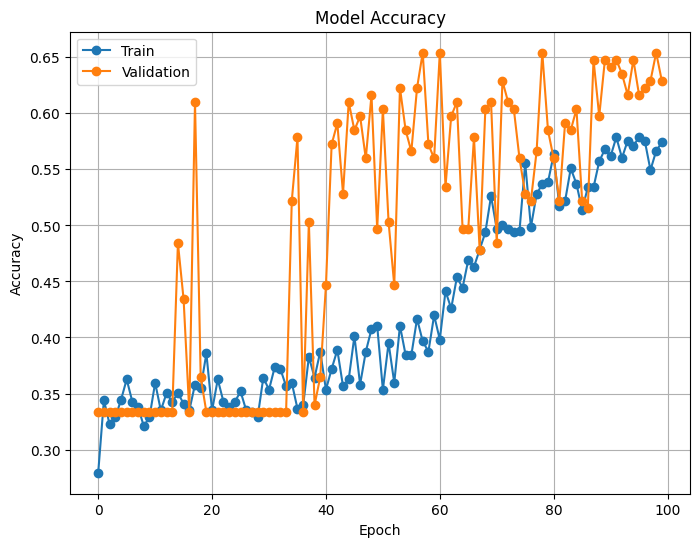

In [ ]:
# Plotting Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], marker='o')
plt.plot(history.history['val_accuracy'], marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.grid(True)
plt.show()

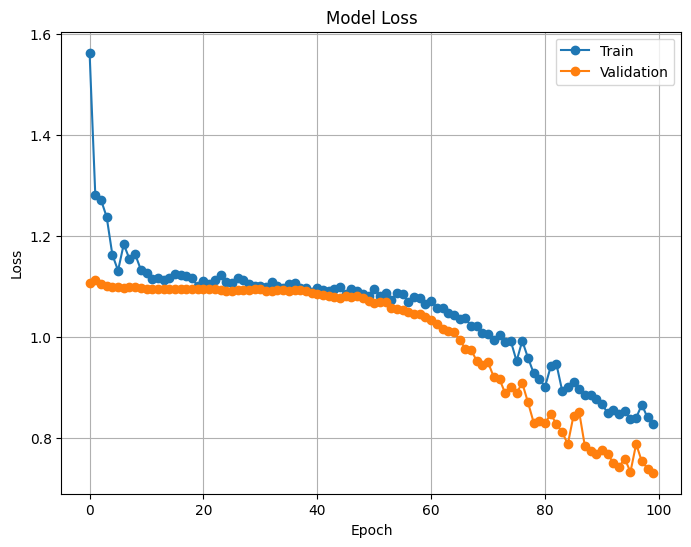

In [ ]:
# Plotting Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], marker='o')
plt.plot(history.history['val_loss'], marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.grid(True)
plt.show()

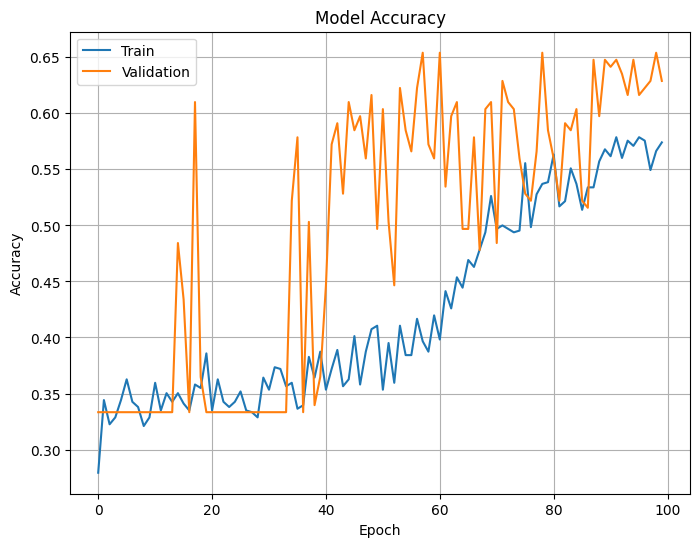

In [ ]:
# Plotting Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.grid(True)
plt.show()

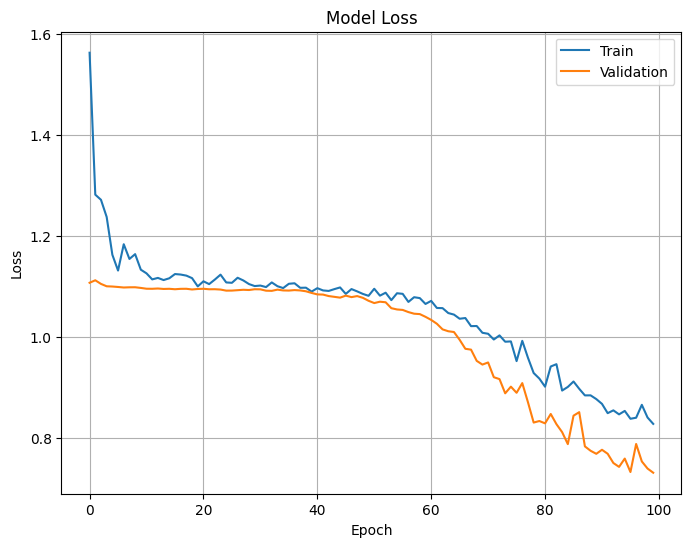

In [ ]:
# Plotting Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.grid(True)
plt.show()